In [89]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras import initializers

from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import coint


def data_preprocess(dta):
    dta['Date'] = pd.to_datetime(dta['Date'], format='%Y-%m-%d')
    dta = dta.set_index(dta['Date'])
    # NHLI not traded
    dta.drop(['Date', 'NHLI'], axis=1, inplace=True)
    dta.dropna(how='all', inplace=True)
    for tick in dta.columns:
        tick_series = dta[tick]
        start_pos = tick_series.first_valid_index()
        valid_series = tick_series.loc[start_pos:]
        if valid_series.isna().sum() > 0:
            dta.drop(tick, axis=1, inplace=True)

    for tick in dta.columns:
        dta[tick] = dta[tick].mask(dta[tick] == 0).ffill(downcast='infer')

    return dta[dta.index >= dta['SPY'].first_valid_index()]


def coeff_deter(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred) * 1e6)
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)) * 1e6)
    return 1 - SS_res / (SS_tot + K.epsilon())


def coint_group(tick, dta):
    """
    Use cointegration test and correlation to find predictive stocks for target
    :param tick: string for the target stock
    :param dta: the data file (csv) that contains the tick
    :return: a list of tickers that are in sp500 which predict the target
    """
    dta['%s_LAG' % tick] = dta[tick].shift(-120)
    dta.dropna(inplace=True)

    y = dta['%s_LAG' % tick]
    cointegrat = {}
    correlat = {}

    for i in dta.columns[:-2]:
        x = dta[i]
        score, pval, _ = coint(x, y, trend='ct')
        corr = x.corr(y)

        cointegrat[i] = pval
        correlat[i] = corr

    best_coint = sorted(cointegrat, key=cointegrat.get)[:10]
    best_corr = sorted(correlat, key=correlat.get, reverse=True)[:10]

    intersect = list(set(best_coint) & set(best_corr))
    print("There are {} cointegrated stocks.".format(len(intersect)))
    return intersect


def measure_profit(tick, fitted_val, asset, dta):
    inventory = 0
    asset = asset
    record = [asset]
    forecast_diff = fitted_val
    T = min(len(forecast_diff), len(dta))

    for t in range(T):
        trend_good = forecast_diff[t] > dta[tick].iloc[t]
        price = dta[tick].iloc[t]
        if trend_good and inventory == 0:
            # buy
            asset -= price
            inventory += 1
        elif not trend_good and inventory == 1:
            # sell
            asset += price
            inventory -= 1
        elif t == len(forecast_diff) - 1 and inventory == 1:
            asset += price
            inventory -= 1
        else:
            asset = record[-1]
        record.append(asset)

    return asset, record[1:]


def regression_mod(X, Y, dta):
    """
    Use basic regression model to forecast
    :param X: list of strings of tickers
    :param Y: string of lagged target ticker
    :param dta: the data set that contains X and Y
    :return: the regression model (statsmodels mod format)
    """
    X = dta[X]
    Y = dta[Y]
    mod = sm.OLS(Y, sm.add_constant(X)).fit()
    return mod


def LSTM_mod(X, Y, scaler_x, scaler_y):
    """
    To adjust lstm machine learning model architecture (layers, activations, kernels...)
    :param X: np arrays
    :param Y: np array (1 dimensional)
    :param scaler_x: a scaler class from sklearn (unfitted)
    :param scaler_y: a scaler class from sklearn (unfitted)
    :return:
    """
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

    scaler_x = scaler_x.fit(X_train)
    scaler_y = scaler_y.fit(Y_train)

    X_train = scaler_x.transform(X_train)
    Y_train = scaler_y.transform(Y_train)

    X_test = scaler_x.transform(X_test)
    Y_test = scaler_y.transform(Y_test)

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    initializer = initializers.glorot_normal(seed=42)
    model = Sequential()
    model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer))
    model.add(Dropout(0.4))
    model.add(Dense(10, kernel_initializer=initializer))
    model.add(Dropout(0.4))
    model.add(Dense(1, kernel_initializer=initializer))
    model.compile(loss='mae', optimizer='adam', metrics=[coeff_deter])

    es = EarlyStopping(monitor='val_coeff_deter', mode='max', patience=5)

    model.fit(X_train, Y_train,
              batch_size=32,
              validation_data=(X_test, Y_test),
              epochs=50,
              callbacks=[es],
              verbose=2)

    return model


sp = pd.read_csv('sp500_stock.csv')
data = pd.read_csv('broader_stock.csv')

sp = data_preprocess(sp)
data = data_preprocess(data)

ticker_list = list(data.columns)
ticker_list.remove('SPY')

tick = 'MSFT'
original_series = data[tick]

if tick in sp.columns:
    original_data = pd.concat([sp.drop([tick], axis=1), original_series], axis=1)
    original_data = original_data[original_data[tick].notnull()].dropna(axis=1)
else:
    original_data = pd.concat([sp, original_series], axis=1)
    original_data = original_data[original_data[tick].notnull()].dropna(axis=1)

cutoff = int(original_data.shape[0] * 0.8)
observed_data = original_data.iloc[:cutoff]

arr = observed_data[tick]

'''
if len(arr) < 2000:
    continue
'''

coint_corr = coint_group(tick, observed_data)


There are 5 cointegrated stocks.


In [90]:

# This is the training period performance.
# regression model
reg_model = regression_mod(coint_corr, '%s_LAG' % tick, observed_data)
y_pred = reg_model.predict()

# examine trading profit
regasset, regrecord = measure_profit(tick, y_pred, 0, observed_data)

In [91]:
regasset

89.29000000000008

In [75]:
import matplotlib.pyplot as plt

In [92]:
test_data = original_data.iloc[cutoff:]
init_asset = 0
regrecord_os = []
prediction_os = []

In [93]:
T = test_data.shape[0] // 120

for i in range(T):
    test_coint_corr = test_data[coint_corr].iloc[i*120:(i+1)*120]
    y_pred_os = reg_model.predict(sm.add_constant(test_coint_corr))
    prediction_os += y_pred_os.to_list()
    init_asset, record = measure_profit(tick, y_pred_os, init_asset, test_data.iloc[i*120:(i+1)*120])
    regrecord_os += record

    # update model after record performance
    new_observed_data = original_data.iloc[i * 120:cutoff + (i+1) * 120]
    coint_corr = coint_group(tick, new_observed_data)

    reg_model = regression_mod(coint_corr, '%s_LAG' % tick, new_observed_data)

test_coint_corr = test_data[coint_corr].iloc[T * 120:]
y_pred_os = reg_model.predict(sm.add_constant(test_coint_corr))
prediction_os += y_pred_os.to_list()
regasset_os, record = measure_profit(tick, y_pred_os, init_asset, test_data.iloc[T * 120:])
regrecord_os += record

There are 4 cointegrated stocks.
There are 5 cointegrated stocks.
There are 4 cointegrated stocks.
There are 3 cointegrated stocks.
There are 3 cointegrated stocks.
There are 2 cointegrated stocks.
There are 2 cointegrated stocks.
There are 2 cointegrated stocks.
There are 2 cointegrated stocks.
There are 3 cointegrated stocks.
There are 2 cointegrated stocks.


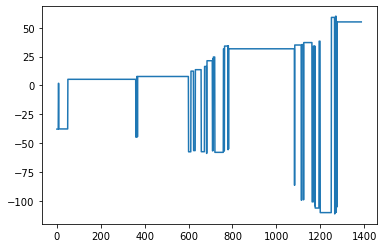

In [94]:
plt.plot(regrecord_os)

In [95]:
np.var(regrecord_os)

1564.3123142223587

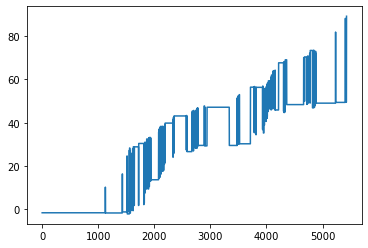

In [97]:
plt.plot(regrecord)

In [96]:
np.var(regrecord)

543.3360954828565

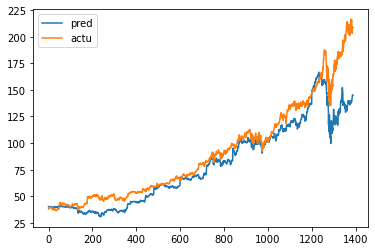

In [86]:
plt.plot(prediction_os)
plt.plot(test_data[tick].values)
plt.legend(['pred', 'actu'])

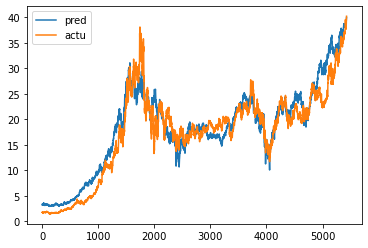

In [87]:
plt.plot(y_pred)
plt.plot(observed_data[tick].values)
plt.legend(['pred', 'actu'])